<a href="https://colab.research.google.com/github/mohit2494/ML-CAP-6610-GAN-VAE/blob/main/Generative_Adversarial_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Generative Adversarial Networks**
----
### Mohit Kalra
### ML CAP 6610

In [82]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [81]:
batch_size = 100
transformed_MNIST =transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))
                            ])
dataset_for_training = datasets.MNIST(
                                root='./mnist_data/', 
                                train=True, 
                                transform=transformed_MNIST, 
                                download=True)
dataset_for_testing = datasets.MNIST(
                                root='./mnist_data/', 
                                train=False, 
                                transform=transformed_MNIST, 
                                download=False)
loader_training = torch.utils.data.DataLoader(
                                dataset=dataset_for_training, 
                                batch_size=batch_size, 
                                shuffle=True)
loader_test = torch.utils.data.DataLoader(
                                dataset=dataset_for_testing, 
                                batch_size=batch_size, 
                                shuffle=False)

In [72]:
class Generator(nn.Module):
    def __init__(self, generator_input_dimension, generator_output_dimension):
        super(Generator, self).__init__()       
        self.input_layer = nn.Linear(generator_input_dimension, 256)
        self.hidden_layer_1 = nn.Linear(self.input_layer.out_features, self.input_layer.out_features*2)
        self.hidden_layer_2 = nn.Linear(self.hidden_layer_1.out_features, self.hidden_layer_1.out_features*2)
        self.hidden_layer_3 = nn.Linear(self.hidden_layer_2.out_features, generator_output_dimension)
    
    def forward(self, x): 
        x = F.leaky_relu(self.input_layer(x), 0.2)
        x = F.leaky_relu(self.hidden_layer_1(x), 0.2)
        x = F.leaky_relu(self.hidden_layer_2(x), 0.2)
        return torch.tanh(self.hidden_layer_3(x))

In [73]:
generator_model

Generator(
  (input_layer): Linear(in_features=100, out_features=256, bias=True)
  (hidden_layer_1): Linear(in_features=256, out_features=512, bias=True)
  (hidden_layer_2): Linear(in_features=512, out_features=1024, bias=True)
  (hidden_layer_3): Linear(in_features=1024, out_features=784, bias=True)
)

In [74]:
class Discriminator(nn.Module):
    def __init__(self, discriminator_input_dimension):
        super(Discriminator, self).__init__()
        self.input_layer = nn.Linear(discriminator_input_dimension, 1024)
        self.hidden_layer_1 = nn.Linear(self.input_layer.out_features, self.input_layer.out_features//2)
        self.hidden_layer_2 = nn.Linear(self.hidden_layer_1.out_features, self.hidden_layer_1.out_features//2)
        self.hidden_layer_3 = nn.Linear(self.hidden_layer_2.out_features, 1)
    
    def forward(self, x):
        x = F.leaky_relu(self.input_layer(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.hidden_layer_1(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.hidden_layer_2(x), 0.2)
        x = F.dropout(x, 0.3)
        return torch.sigmoid(self.hidden_layer_3(x))

In [75]:
discriminator_model

Discriminator(
  (input_layer): Linear(in_features=784, out_features=1024, bias=True)
  (hidden_layer_1): Linear(in_features=1024, out_features=512, bias=True)
  (hidden_layer_2): Linear(in_features=512, out_features=256, bias=True)
  (hidden_layer_3): Linear(in_features=256, out_features=1, bias=True)
)

In [76]:
latent_space_dimension = 100
mnist_data_dimension = dataset_for_training.train_data.size(1) * dataset_for_training.train_data.size(2)
generator_model = Generator(generator_input_dimension = latent_space_dimension, generator_output_dimension = mnist_data_dimension).to(device)
discriminator_model = Discriminator(mnist_data_dimension).to(device)

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:58: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


In [77]:
criterion = nn.BCELoss() 
learning_rate = 0.0002 
generator_optimizer = optim.Adam(generator_model.parameters(), lr = learning_rate)
discriminator_optimizer = optim.Adam(discriminator_model.parameters(), lr = learning_rate)

In [78]:
def train_discriminator(x):
    discriminator_model.zero_grad()
    real_x, real_y = x.view(-1, mnist_data_dimension), torch.ones(batch_size, 1)
    real_x, real_y = Variable(real_x.to(device)), Variable(real_y.to(device))
    discriminator_output = discriminator_model(real_x)
    discriminator_real_value_loss = criterion(discriminator_output, real_y)
    discriminator_score_over_real = discriminator_output
    z = Variable(torch.randn(batch_size, latent_space_dimension).to(device))
    fake_x, fake_ = generator_model(z), Variable(torch.zeros(batch_size, 1).to(device))
    discriminator_output = discriminator_model(fake_x)
    discriminator_loss_over_fake = criterion(discriminator_output, fake_)
    discriminator_score_over_fake = discriminator_output
    total_discriminator_loss = discriminator_real_value_loss + discriminator_loss_over_fake
    total_discriminator_loss.backward()
    discriminator_optimizer.step()
    return  total_discriminator_loss.data.item()

In [79]:
def train_generator(x):
    generator_model.zero_grad()
    z = Variable(torch.randn(batch_size, latent_space_dimension).to(device))
    y = Variable(torch.ones(batch_size, 1).to(device))
    generator_output = generator_model(z)
    discriminator_output = discriminator_model(generator_output)
    generator_loss = criterion(discriminator_output, y)
    generator_loss.backward()
    generator_optimizer.step()
    return generator_loss.data.item()

[1/200]: loss_d: 1.001, loss_g: 2.415
[2/200]: loss_d: 1.142, loss_g: 1.780
[3/200]: loss_d: 1.189, loss_g: 1.298
[4/200]: loss_d: 1.035, loss_g: 1.817
[5/200]: loss_d: 0.761, loss_g: 2.126
[6/200]: loss_d: 0.633, loss_g: 2.533
[7/200]: loss_d: 0.601, loss_g: 2.396
[8/200]: loss_d: 0.724, loss_g: 2.271
[9/200]: loss_d: 0.647, loss_g: 2.297
[10/200]: loss_d: 0.724, loss_g: 2.209


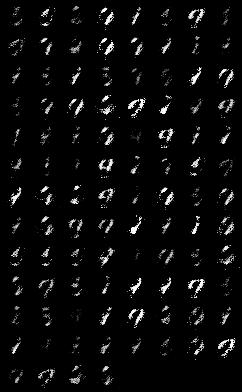

[11/200]: loss_d: 0.660, loss_g: 2.283
[12/200]: loss_d: 0.665, loss_g: 2.324
[13/200]: loss_d: 0.691, loss_g: 2.311
[14/200]: loss_d: 0.718, loss_g: 2.138
[15/200]: loss_d: 0.734, loss_g: 2.116
[16/200]: loss_d: 0.826, loss_g: 1.857
[17/200]: loss_d: 0.848, loss_g: 1.778
[18/200]: loss_d: 0.829, loss_g: 1.826
[19/200]: loss_d: 0.829, loss_g: 1.824
[20/200]: loss_d: 0.839, loss_g: 1.817


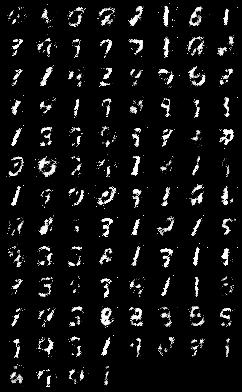

[21/200]: loss_d: 0.821, loss_g: 1.845
[22/200]: loss_d: 0.870, loss_g: 1.678
[23/200]: loss_d: 0.920, loss_g: 1.603
[24/200]: loss_d: 0.930, loss_g: 1.556
[25/200]: loss_d: 0.942, loss_g: 1.505
[26/200]: loss_d: 0.941, loss_g: 1.508
[27/200]: loss_d: 0.940, loss_g: 1.557
[28/200]: loss_d: 0.987, loss_g: 1.448
[29/200]: loss_d: 0.994, loss_g: 1.414
[30/200]: loss_d: 0.989, loss_g: 1.419


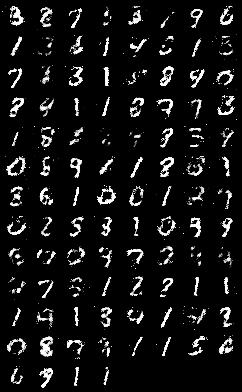

[31/200]: loss_d: 1.027, loss_g: 1.350
[32/200]: loss_d: 1.033, loss_g: 1.330
[33/200]: loss_d: 1.038, loss_g: 1.307
[34/200]: loss_d: 1.068, loss_g: 1.253
[35/200]: loss_d: 1.066, loss_g: 1.276
[36/200]: loss_d: 1.063, loss_g: 1.288
[37/200]: loss_d: 1.074, loss_g: 1.267
[38/200]: loss_d: 1.090, loss_g: 1.218
[39/200]: loss_d: 1.077, loss_g: 1.240
[40/200]: loss_d: 1.106, loss_g: 1.201


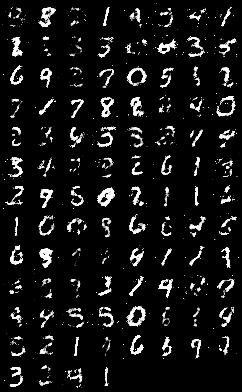

[41/200]: loss_d: 1.092, loss_g: 1.225
[42/200]: loss_d: 1.104, loss_g: 1.206
[43/200]: loss_d: 1.115, loss_g: 1.165
[44/200]: loss_d: 1.122, loss_g: 1.161
[45/200]: loss_d: 1.107, loss_g: 1.187
[46/200]: loss_d: 1.115, loss_g: 1.175
[47/200]: loss_d: 1.139, loss_g: 1.139
[48/200]: loss_d: 1.130, loss_g: 1.141
[49/200]: loss_d: 1.127, loss_g: 1.155
[50/200]: loss_d: 1.147, loss_g: 1.124


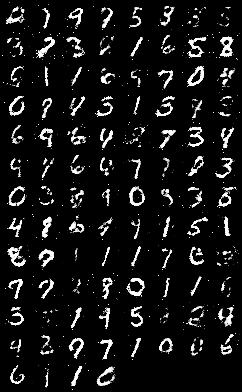

[51/200]: loss_d: 1.155, loss_g: 1.110
[52/200]: loss_d: 1.160, loss_g: 1.085
[53/200]: loss_d: 1.177, loss_g: 1.082
[54/200]: loss_d: 1.179, loss_g: 1.067
[55/200]: loss_d: 1.173, loss_g: 1.073
[56/200]: loss_d: 1.170, loss_g: 1.077
[57/200]: loss_d: 1.173, loss_g: 1.079
[58/200]: loss_d: 1.187, loss_g: 1.058
[59/200]: loss_d: 1.184, loss_g: 1.062
[60/200]: loss_d: 1.177, loss_g: 1.067


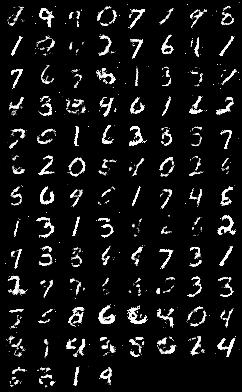

[61/200]: loss_d: 1.187, loss_g: 1.045
[62/200]: loss_d: 1.205, loss_g: 1.012
[63/200]: loss_d: 1.214, loss_g: 1.002
[64/200]: loss_d: 1.210, loss_g: 1.025
[65/200]: loss_d: 1.203, loss_g: 1.015
[66/200]: loss_d: 1.209, loss_g: 0.999
[67/200]: loss_d: 1.228, loss_g: 0.983
[68/200]: loss_d: 1.217, loss_g: 1.003
[69/200]: loss_d: 1.218, loss_g: 0.983
[70/200]: loss_d: 1.216, loss_g: 0.995


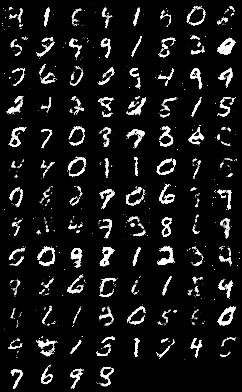

[71/200]: loss_d: 1.229, loss_g: 0.990
[72/200]: loss_d: 1.222, loss_g: 0.994
[73/200]: loss_d: 1.218, loss_g: 0.991
[74/200]: loss_d: 1.229, loss_g: 0.967
[75/200]: loss_d: 1.223, loss_g: 0.994
[76/200]: loss_d: 1.228, loss_g: 0.964
[77/200]: loss_d: 1.237, loss_g: 0.966
[78/200]: loss_d: 1.242, loss_g: 0.955
[79/200]: loss_d: 1.232, loss_g: 0.969
[80/200]: loss_d: 1.228, loss_g: 0.982


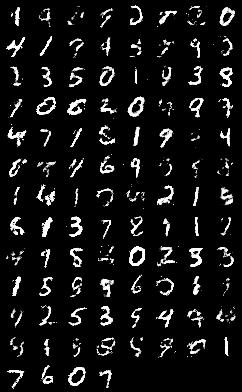

[81/200]: loss_d: 1.233, loss_g: 0.983
[82/200]: loss_d: 1.236, loss_g: 0.954
[83/200]: loss_d: 1.245, loss_g: 0.952
[84/200]: loss_d: 1.242, loss_g: 0.959
[85/200]: loss_d: 1.248, loss_g: 0.943
[86/200]: loss_d: 1.244, loss_g: 0.941
[87/200]: loss_d: 1.245, loss_g: 0.947
[88/200]: loss_d: 1.242, loss_g: 0.960
[89/200]: loss_d: 1.245, loss_g: 0.956
[90/200]: loss_d: 1.242, loss_g: 0.953


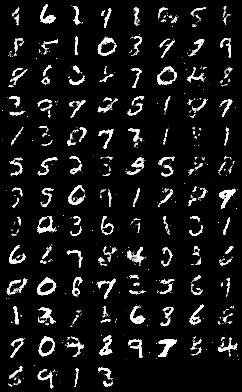

[91/200]: loss_d: 1.249, loss_g: 0.938
[92/200]: loss_d: 1.250, loss_g: 0.942
[93/200]: loss_d: 1.252, loss_g: 0.946
[94/200]: loss_d: 1.261, loss_g: 0.919
[95/200]: loss_d: 1.261, loss_g: 0.918
[96/200]: loss_d: 1.258, loss_g: 0.922
[97/200]: loss_d: 1.258, loss_g: 0.941
[98/200]: loss_d: 1.258, loss_g: 0.950
[99/200]: loss_d: 1.261, loss_g: 0.929
[100/200]: loss_d: 1.267, loss_g: 0.918


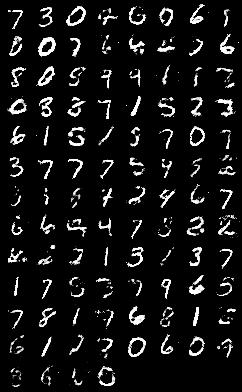

[101/200]: loss_d: 1.265, loss_g: 0.922
[102/200]: loss_d: 1.262, loss_g: 0.921
[103/200]: loss_d: 1.261, loss_g: 0.920
[104/200]: loss_d: 1.268, loss_g: 0.928
[105/200]: loss_d: 1.262, loss_g: 0.917
[106/200]: loss_d: 1.267, loss_g: 0.917
[107/200]: loss_d: 1.264, loss_g: 0.923
[108/200]: loss_d: 1.262, loss_g: 0.909
[109/200]: loss_d: 1.271, loss_g: 0.905
[110/200]: loss_d: 1.272, loss_g: 0.904


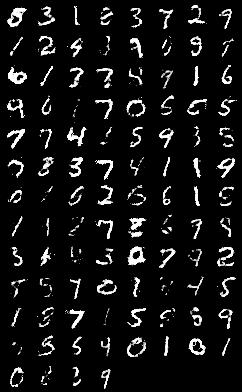

[111/200]: loss_d: 1.266, loss_g: 0.922
[112/200]: loss_d: 1.263, loss_g: 0.919
[113/200]: loss_d: 1.268, loss_g: 0.906
[114/200]: loss_d: 1.263, loss_g: 0.937
[115/200]: loss_d: 1.266, loss_g: 0.920
[116/200]: loss_d: 1.266, loss_g: 0.903
[117/200]: loss_d: 1.268, loss_g: 0.908
[118/200]: loss_d: 1.269, loss_g: 0.906
[119/200]: loss_d: 1.268, loss_g: 0.910
[120/200]: loss_d: 1.265, loss_g: 0.919


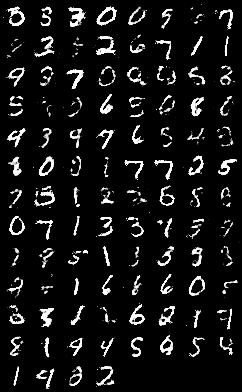

[121/200]: loss_d: 1.264, loss_g: 0.919
[122/200]: loss_d: 1.272, loss_g: 0.902
[123/200]: loss_d: 1.273, loss_g: 0.905
[124/200]: loss_d: 1.271, loss_g: 0.906
[125/200]: loss_d: 1.273, loss_g: 0.901
[126/200]: loss_d: 1.272, loss_g: 0.910
[127/200]: loss_d: 1.273, loss_g: 0.896
[128/200]: loss_d: 1.274, loss_g: 0.904
[129/200]: loss_d: 1.267, loss_g: 0.908
[130/200]: loss_d: 1.274, loss_g: 0.910


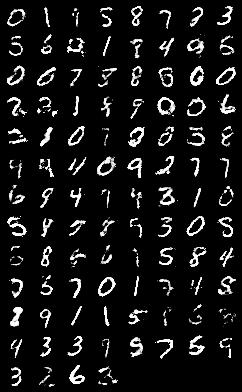

[131/200]: loss_d: 1.273, loss_g: 0.899
[132/200]: loss_d: 1.279, loss_g: 0.892
[133/200]: loss_d: 1.274, loss_g: 0.914
[134/200]: loss_d: 1.277, loss_g: 0.887
[135/200]: loss_d: 1.273, loss_g: 0.912
[136/200]: loss_d: 1.274, loss_g: 0.907
[137/200]: loss_d: 1.276, loss_g: 0.897
[138/200]: loss_d: 1.280, loss_g: 0.887
[139/200]: loss_d: 1.287, loss_g: 0.875
[140/200]: loss_d: 1.282, loss_g: 0.897


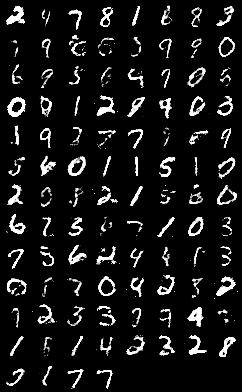

[141/200]: loss_d: 1.278, loss_g: 0.897
[142/200]: loss_d: 1.285, loss_g: 0.878
[143/200]: loss_d: 1.270, loss_g: 0.919
[144/200]: loss_d: 1.275, loss_g: 0.897
[145/200]: loss_d: 1.283, loss_g: 0.888
[146/200]: loss_d: 1.279, loss_g: 0.882
[147/200]: loss_d: 1.283, loss_g: 0.878
[148/200]: loss_d: 1.278, loss_g: 0.896
[149/200]: loss_d: 1.279, loss_g: 0.890
[150/200]: loss_d: 1.280, loss_g: 0.897


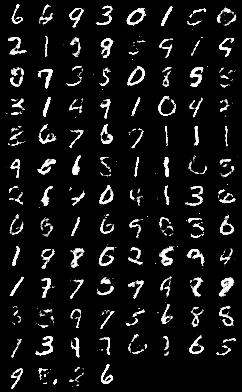

[151/200]: loss_d: 1.277, loss_g: 0.891
[152/200]: loss_d: 1.282, loss_g: 0.887
[153/200]: loss_d: 1.276, loss_g: 0.895
[154/200]: loss_d: 1.281, loss_g: 0.881
[155/200]: loss_d: 1.288, loss_g: 0.878
[156/200]: loss_d: 1.277, loss_g: 0.899
[157/200]: loss_d: 1.278, loss_g: 0.899
[158/200]: loss_d: 1.277, loss_g: 0.891
[159/200]: loss_d: 1.282, loss_g: 0.892
[160/200]: loss_d: 1.282, loss_g: 0.883


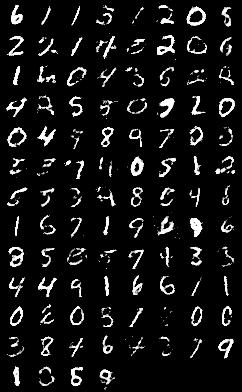

[161/200]: loss_d: 1.277, loss_g: 0.887
[162/200]: loss_d: 1.281, loss_g: 0.889
[163/200]: loss_d: 1.282, loss_g: 0.903
[164/200]: loss_d: 1.285, loss_g: 0.881
[165/200]: loss_d: 1.287, loss_g: 0.869
[166/200]: loss_d: 1.289, loss_g: 0.874
[167/200]: loss_d: 1.290, loss_g: 0.874
[168/200]: loss_d: 1.285, loss_g: 0.879
[169/200]: loss_d: 1.289, loss_g: 0.877
[170/200]: loss_d: 1.287, loss_g: 0.878


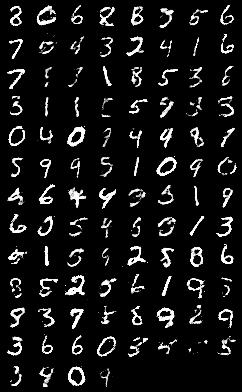

[171/200]: loss_d: 1.283, loss_g: 0.885
[172/200]: loss_d: 1.280, loss_g: 0.890
[173/200]: loss_d: 1.279, loss_g: 0.883
[174/200]: loss_d: 1.278, loss_g: 0.889
[175/200]: loss_d: 1.284, loss_g: 0.880
[176/200]: loss_d: 1.282, loss_g: 0.882
[177/200]: loss_d: 1.285, loss_g: 0.881
[178/200]: loss_d: 1.282, loss_g: 0.881
[179/200]: loss_d: 1.280, loss_g: 0.891
[180/200]: loss_d: 1.282, loss_g: 0.880


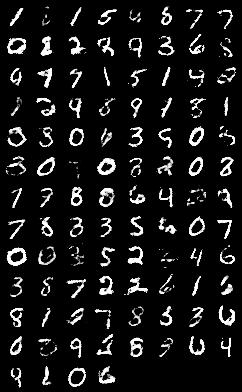

[181/200]: loss_d: 1.282, loss_g: 0.880
[182/200]: loss_d: 1.287, loss_g: 0.879
[183/200]: loss_d: 1.284, loss_g: 0.875
[184/200]: loss_d: 1.287, loss_g: 0.893
[185/200]: loss_d: 1.278, loss_g: 0.897
[186/200]: loss_d: 1.282, loss_g: 0.878
[187/200]: loss_d: 1.289, loss_g: 0.876
[188/200]: loss_d: 1.288, loss_g: 0.877
[189/200]: loss_d: 1.284, loss_g: 0.882
[190/200]: loss_d: 1.290, loss_g: 0.877


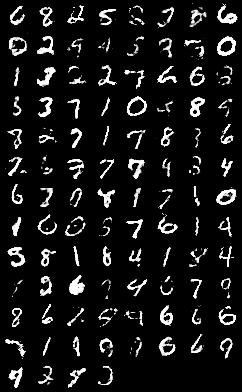

[191/200]: loss_d: 1.289, loss_g: 0.873
[192/200]: loss_d: 1.287, loss_g: 0.876
[193/200]: loss_d: 1.284, loss_g: 0.876
[194/200]: loss_d: 1.282, loss_g: 0.887
[195/200]: loss_d: 1.284, loss_g: 0.878
[196/200]: loss_d: 1.290, loss_g: 0.874
[197/200]: loss_d: 1.284, loss_g: 0.887
[198/200]: loss_d: 1.280, loss_g: 0.886
[199/200]: loss_d: 1.284, loss_g: 0.887
[200/200]: loss_d: 1.285, loss_g: 0.870


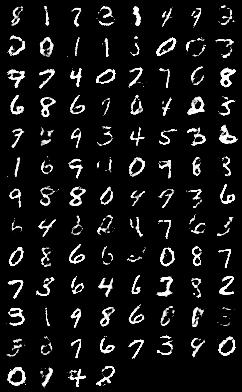

In [80]:
from PIL import Image
from IPython.display import display

def snapshot(id):
    with torch.no_grad():
        test_latent_space = Variable(torch.randn(batch_size, latent_space_dimension).to(device))
        generated = generator_model(test_latent_space)
        filename = 'epoch_'+str(id)+ '.jpg'
        save_image(generated.view(generated.size(0), 1, 28, 28), filename)
        pil_im = Image.open(filename)
        display(pil_im)
        
current_epoch = 0
total_epochs = 200
take_snap = 10

for epoch in range(1, total_epochs+1):           
    discriminator_losses, generator_losses = [], []
    for batch_idx, (x, _) in enumerate(loader_training):
        discriminator_losses.append(train_discriminator(x))
        generator_losses.append(train_generator(x))

    print('[%d/%d]: loss_d: %.3f, loss_g: %.3f' % (
            (epoch), 
            total_epochs, 
            torch.mean(torch.FloatTensor(discriminator_losses)), 
            torch.mean(torch.FloatTensor(generator_losses))))
    
    current_epoch+=1
    if current_epoch%take_snap==0:
        snapshot(current_epoch)